# **Data Cleaning Notebook**

## Objectives

*   Evaluate missing data
*   Clean data

## Inputs

* outputs/datasets/collection/airplane_performance_study.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## Conclusions

 
  * Data Cleaning Pipeline
  * Drop Variables:  `['Model', 'Company', 'THR', 'SHP']`



---


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design'

---

# Load Collected data

In [4]:
import pandas as pd
df_raw_path = "/workspace/data-driven-design/outputs/datasets/collection/airplane_performance_study.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,Model,Company,Wing Span,Length,Height,Multi Engine,TP mods,Engine Type,THR,SHP,...,Vstall,Range,Hmax,Hmax (One),ROC,ROC (One),Vlo,Slo,Vl,Sl
0,15 AC Sedan,Aeronca,37.416667,25.250000,10.250000,False,False,0,NaN,145.0,...,46.0,370.0,13000.0,13000.0,450.0,450.0,900.0,391.970247,1300.0,257.745075
1,11 CC Super Chief,Aeronca,36.083333,20.583333,8.750000,False,False,0,NaN,85.0,...,44.0,190.0,12300.0,12300.0,600.0,600.0,720.0,26.247647,800.0,225.324824
2,7 CCM Champ,Aeronca,35.000000,21.416667,8.583333,False,False,0,NaN,90.0,...,37.0,210.0,16000.0,16000.0,650.0,650.0,475.0,363.139711,850.0,585.751317


# Data Exploration

In Data Cleaning you are interested to check the distribution and shape of a variable with missing data.

The missing data flagged by the "df.isna().sum() > 0" - test is because the different airplanes (the different data points) has different types of propulsion (jet, piston or propjet) and that "size" or "effectiveness" of the propulsion is measured with different quantities and therefore also with different units. The jet is measured in quantity of force (uniot: THR) and the piston and propjet (both using a propeller) is measured using power (unit: SHP). For this reason these units are split into two separate columns depending on what engine type is indicated in the Engine Type column.

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['THR', 'SHP']

In [6]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation and PPS Analysis

In [7]:
pip install ppscore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 212.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
visions 0.7.6 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


Calculate Correlations and Power Predictive Score

In below cell I have to drop values to make the correlation below to work. Why do I have to drop these values when the Churnometer did not have to drop any columns to work!?

In [9]:
# Columns to drop
columns_to_drop = ['Model', 'Company', 'Engine Type', 'TP mods']

# Dropping the columns
df_dropped = df.drop(columns=columns_to_drop)

# Display the modified DataFrame
print(df_dropped)


     Wing Span     Length     Height  Multi Engine  THR    SHP     AUW  \
0    37.416667  25.250000  10.250000         False  NaN  145.0  2050.0   
1    36.083333  20.583333   8.750000         False  NaN   85.0  1350.0   
2    35.000000  21.416667   8.583333         False  NaN   90.0  1300.0   
3    35.000000  21.416667   8.583333         False  NaN   85.0  1300.0   
4    35.000000  21.416667   8.750000         False  NaN   65.0  1220.0   
..         ...        ...        ...           ...  ...    ...     ...   
855  49.416667  35.083333  14.416667          True  NaN  260.0  6250.0   
856  49.000000  35.083333  14.416667          True  NaN  250.0  6000.0   
857  44.083333  35.416667  14.416667          True  NaN  260.0  5500.0   
858  30.000000  21.166667   7.000000         False  NaN  180.0  1817.0   
859  30.000000  21.166667   7.000000         False  NaN  150.0  1817.0   

        MEW      FW   Vmax  ...  Vstall   Range     Hmax  Hmax (One)     ROC  \
0    1180.0   241.2  104.0  ...

In [10]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_dropped)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min    25%    50%    75%    max
ppscore  420.0  0.396  0.238  0.0  0.212  0.427  0.564  0.903


Display at Heatmaps

In [11]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [12]:
df = pd.DataFrame(df_dropped)
print(df.dtypes)

# column_dtype = df_dropped.dtype
# print(column_dtype)


Wing Span       float64
Length          float64
Height          float64
Multi Engine       bool
THR             float64
SHP             float64
AUW             float64
MEW             float64
FW              float64
Vmax            float64
Vcruise         float64
Vstall          float64
Range           float64
Hmax            float64
Hmax (One)      float64
ROC             float64
ROC (One)       float64
Vlo             float64
Slo             float64
Vl              float64
Sl              float64
dtype: object


Solve issue with "AttributeError: model 'numpy' has no attribute 'bool'. 'np.bool' was a deprecated alias for the builtin 'bool'..."

In [13]:
import numpy as np
np.bool = np.bool_

Solve issue that the plots were not being displayed

In [14]:
%matplotlib inline

We have added the Predictive Power Score (PPS) since PPS also can detect non-linear relationships that the traditional metrics like Pearson or Spearman correlations might miss.

Observations and conclusion from below heatmaps:

* We naturally see high correlation between features of the same kind, e.g. we see high correlation (0,85 - 0,88) between the "weight"-features like "All Up Weight" (AUW), Fuel Weight(FW) and "Manufacturer Empty Weight" (MEW) since both are "weight"-features. We also see high correlation between features in related kinds, e.g. the size of the airplane (Height, Length and Wing Span) are obvioously strongly related to airplanes weight (AUW, FW and MEW).

Albeit not really interresting from an Airplane Design perspective these relationships can still be used to predict values in a meaningfull way. Note also that it due to structural and aerodynamic Scale factors the relatinship between size and weight might not be linear. 

* Interesting correlation between: 0.8 - 1.0:



Now we run the correlation again with elevated thressholds as to only filter out the weakly correlation values leaving only **moderate** to **strongly** correlated features



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



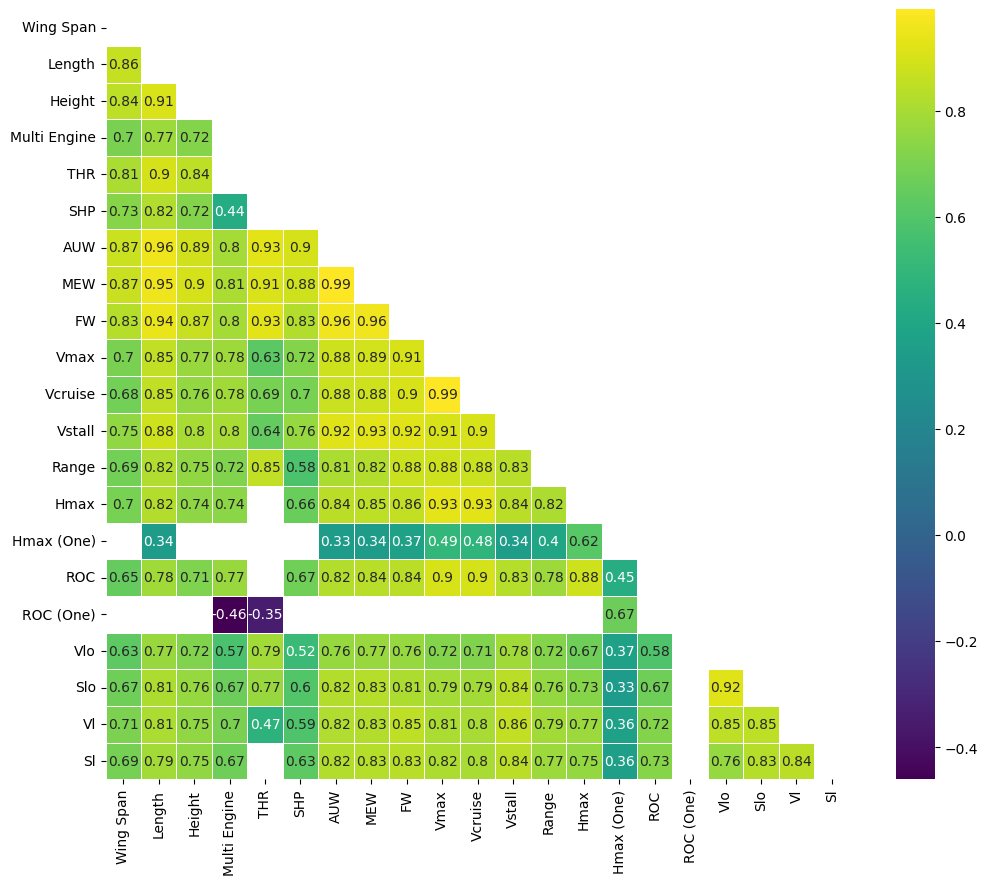



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



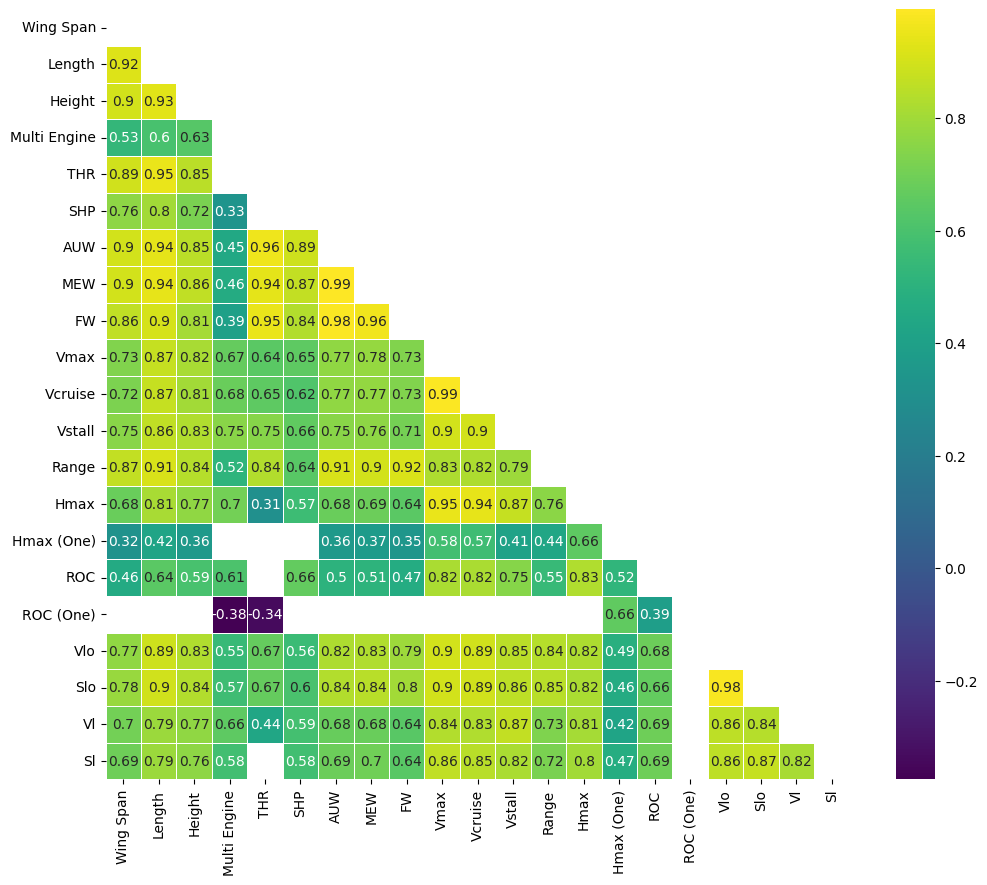



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



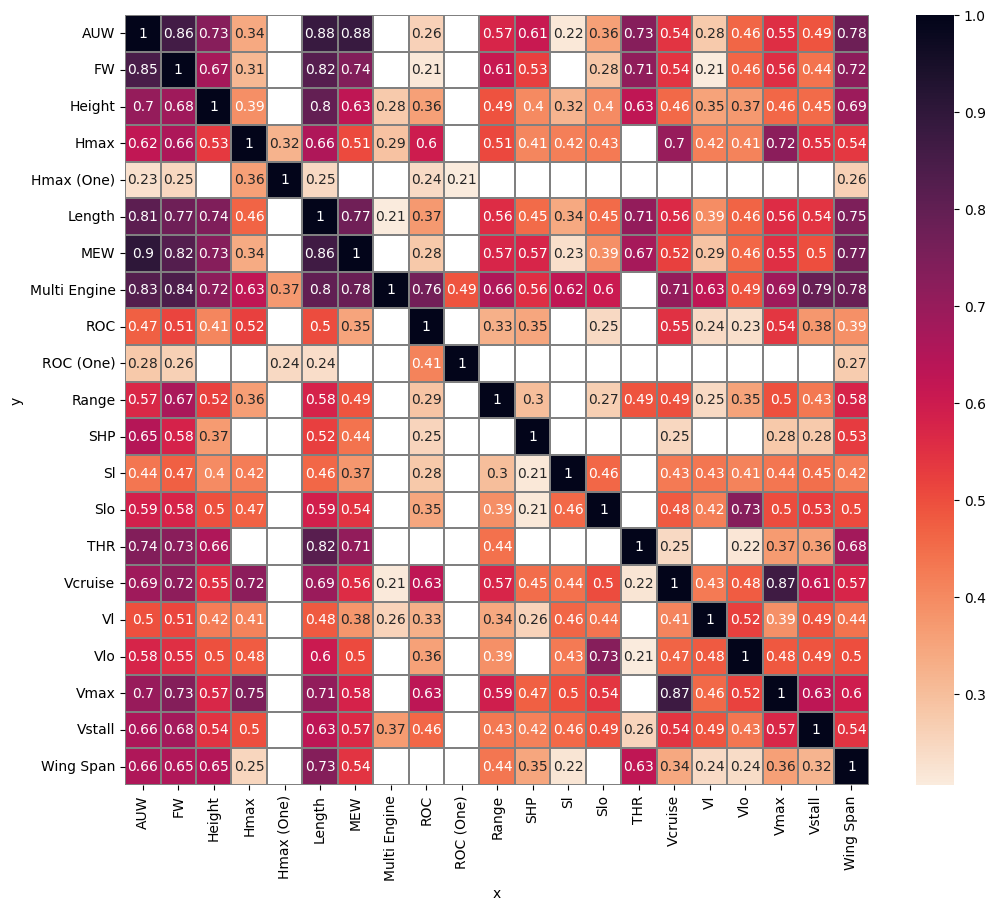

In [15]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.3, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

Now we run the correlation again with elevated thresholds as to only filter out both weakly and moderate correlation values leaving only **strongly** correlated features



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



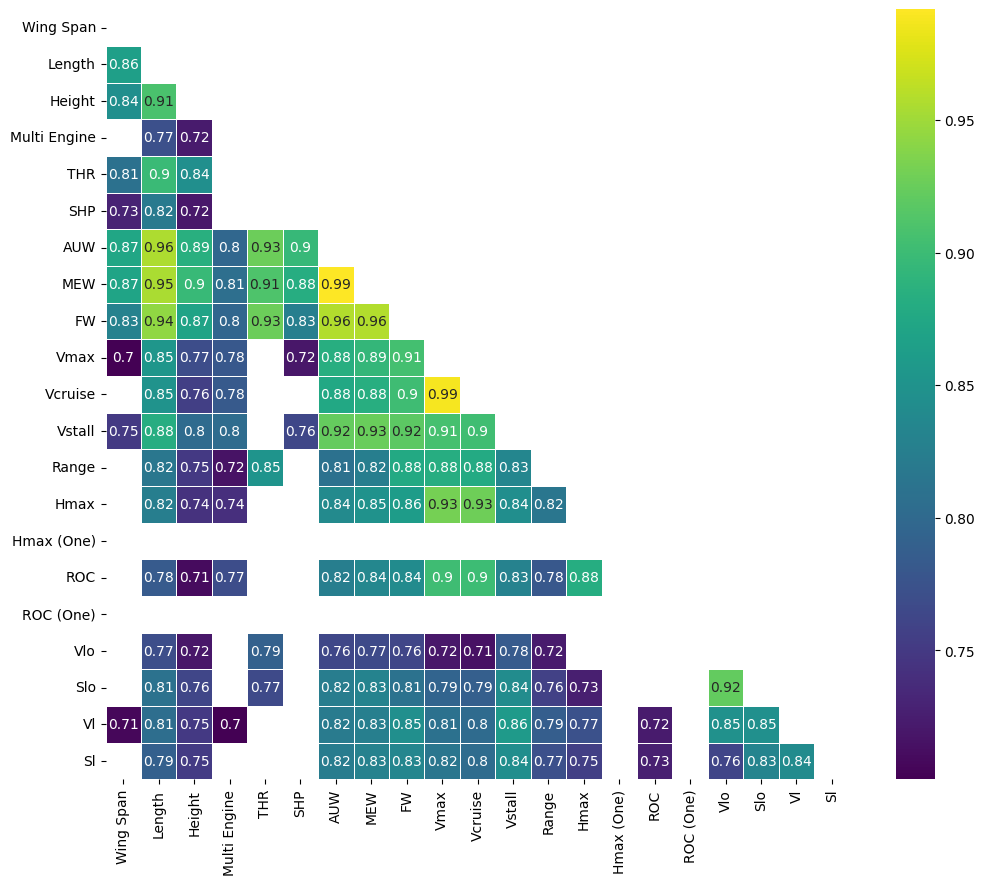



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



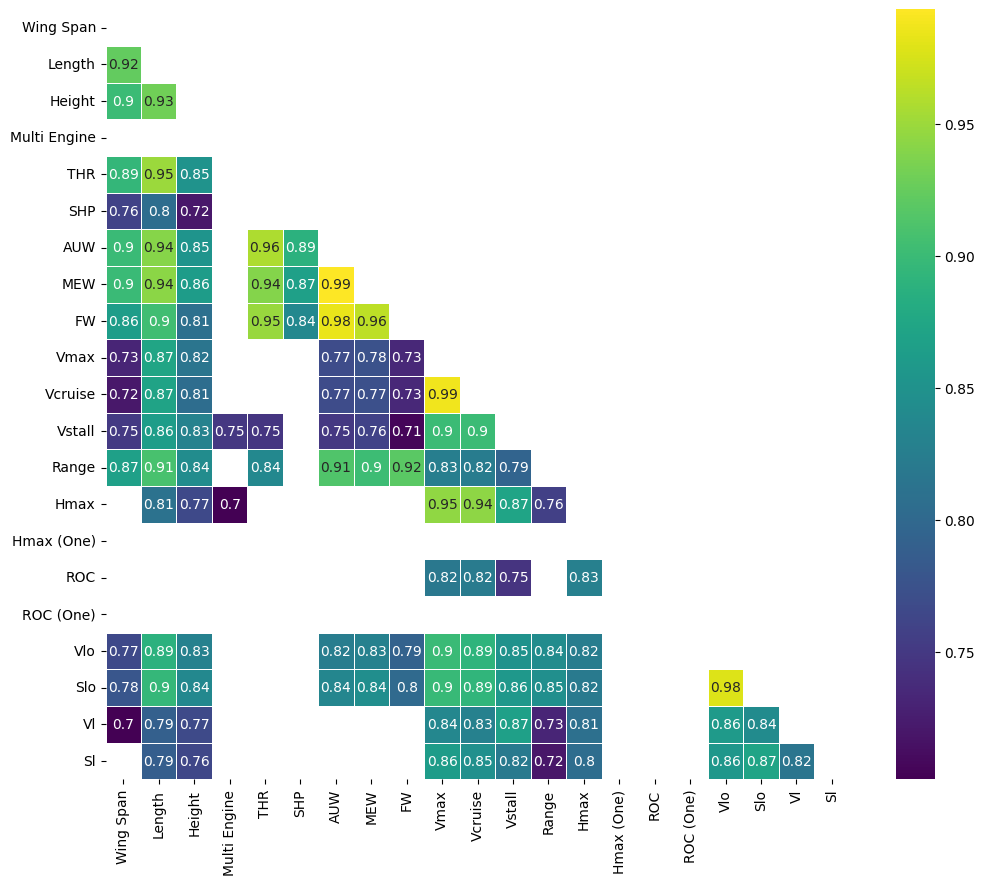



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



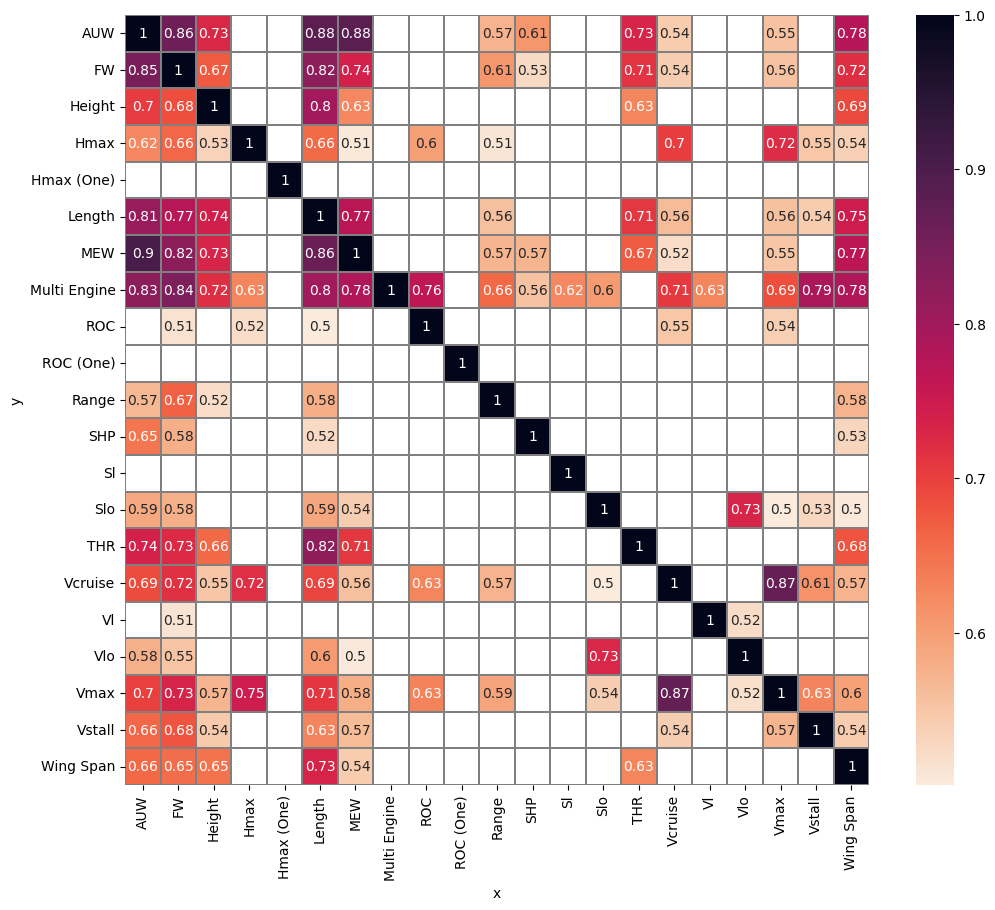

In [16]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.7, PPS_Threshold =0.5,
                  figsize=(12,10), font_annot=10)

# Data Cleaning

## Assessing Missing Data Levels

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [17]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data


Check missing data levels for the collected dataset.

In [18]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
THR,704,81.86,float64
SHP,156,18.14,float64


## Data Cleaning Spreadsheet Summary

* Consider your spreadsheet notes on potential approaches to handle missing data


## Dealing with Missing Data

This dataset doesn't require much data cleaning, therefore we are not loading the DataCleaningEffect() function we studied in the feature-engine lesson.
* For your future projects, this would be a moment to load that function and use it over your data-cleaning process.
* For this project, we are skipping this part.

### Data Cleaning Summary

List here the data cleaning approaches you want initially to try.
* Drop - `['customerID', 'TotalCharges' ]`


**The list above is your guide, your map to know at which stage you are in the data-cleaning process**

### Split Train and Test Set

In [19]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['Multi Engine'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (688, 21) 
TestSet shape: (172, 21)


In [20]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 2 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
THR,564,81.98,float64
SHP,124,18.02,float64


### Drop Variables


* Hint: you may drop Variables with more than 80% of missing data since these variables will likely not add much value. However, this is not the case in this dataset
* Step 1: imputation approach: **Drop Variables**
* Step 2: Select variables to apply the imputation approach


In [21]:
variables_method = ['THR', 'SHP' ]

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")


* 2 variables to drop 

['THR', 'SHP']


* We are dropping `CustomerID` since it is a unique identifier for each customer, it doesn't add information to the dataset as it is.
* We are dropping `TotalCharges` as for the context of the ML projects, a prospect doesn't have `TotalCharges`.

* Step 3: Create a separate DataFrame applying this imputation approach to the selected variables.

In [22]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

* Step 4: Assess the effect on the variable's distribution.

* In this case, there is no effect on the distribution of the variable, since you are not removing rows, but columns.
* The effect might be losing features that might have a relevant impact on your machine-learning model.

* Step 5: If you are satisfied, apply the transformation to your data.

In [23]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

* Step 6: Evaluate if you have more variables to deal with. If yes, iterate. If not, you are done.

In [24]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType


# Push cleaned data to Repo

In [25]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)


## Train Set

In [26]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test Set

In [27]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)

Good job! Clear cell outputs

Well done! You can now push the changes to your GitHub Repo, using the Git commands (git add, git commit, git push)